In [1]:
import array
from PIL import Image
from json import load
import pandas as pd
import rpy2.robjects as ro
import rpy2.robjects.vectors as rvec
from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
import numpy as np
import matplotlib.pyplot as plt
Image.MAX_IMAGE_PIXELS = None

# Load EBImage package from R
EBImage = importr('EBImage')

def convert_to_df(data):
    # Check if data is an R Matrix
    if isinstance(data, rvec.Matrix):
        return pandas2ri.rpy2py(ro.r['as.data.frame'](data))
    elif isinstance(data, rvec.Vector):
        return pandas2ri.rpy2py(data)
    # Check if data is an R DataFrame
    elif isinstance(data, rvec.DataFrame):
        return pandas2ri.rpy2py(data)

    # Check if data is an EBImage object (matrix or image)
    elif isinstance(data, ro.rinterface.Sexp):
        # Check if it's an EBImage object (usually matrix)
        try:
            ro.r('library(EBImage)')
            image_array = ro.r['imageData'](data)  # Convert EBImage object to matrix
            if isinstance(image_array, rvec.Matrix):
                # Convert the image matrix to a DataFrame (pixel values)
                return pd.DataFrame(pandas2ri.rpy2py(image_array))
        except Exception as e:
            print(f"Error converting EBImage object: {e}")
            return None

    # Return None for unsupported data types
    else:
        return None
# Activate the automatic conversion of R objects to pandas objects
pandas2ri.activate()






In [2]:
annotated_only = True

In [9]:
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from natsort import natsorted



#paths
dataDir = "/storage/research/dbmr_luisierlab/database/ST_TNBC_v3"
cancer_percentage_thresholed = 0.5

if annotated_only:
    images_name_list = natsorted([os.path.basename(f).replace('.png', '.jpg') for f in glob.glob(f"{dataDir}/Images/imageAnnotations/*.png")])
    images_filenames_spot_patches = [f"{dataDir}/Images/imagesHD/{image}" for image in images_name_list]
    images_filenames_spot_patches_low_res = [f"{dataDir}/Images/imagesLarge/{image}" for image in images_name_list]
else:
    images_filenames_spot_patches = natsorted(glob.glob(f"{dataDir}/Images/imagesHD/*.jpg"))
    images_filenames_spot_patches_low_res = natsorted(glob.glob(f"{dataDir}/Images/imagesLarge/*.jpg"))
    images_name_list = [os.path.basename(f) for f in images_filenames_spot_patches]


spots_path = [f"{dataDir}/byArray/{image.split('_')[1]}/{image.split('_')[2][:2]}/allSpots.RDS" for image in images_name_list]


In [10]:
images_filenames_spot_patches

['/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC1_CN1_C1.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC2_CN1_E1.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC3_CN2_C1.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC4_CN2_D2.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC5_CN3_D1.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC6_CN3_E1.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC7_CN4_D1.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC8_CN4_D2.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC9_CN5_D1.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC10_CN5_E1.jpg',
 '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC11_CN6_C1.jpg

In [11]:
# Initialize an empty list to store DataFrames
spots_dfs = []

# Process each RDS file
idxs_to_remove = []
for spots in spots_path:
    if not os.path.exists(spots):
        print(f"File not found: {spots}")
        idx = spots_path.index(spots)
        idxs_to_remove.append(idx)

        continue

    try:
        # Read the RDS file
        spots_df = robjects.r['readRDS'](spots)

        spots_df = convert_to_df(spots_df)
        # Add a column to track the source file
        spots_df['pixel_x'] = spots_df['pixel_x'] * 10.0 / 3.0 # This is to get the coordinates in the HD image (31*744*31744 px). Reminder: the large image is 9523*9523px.
        spots_df['pixel_y'] = spots_df['pixel_y'] * 10.0 / 3.0 # This is to get the coordinates in the HD image (31*744*31744 px). Reminder: the large image is 9523*9523px.
        # Append to the list of DataFrames
        spots_dfs.append(spots_df)

    except Exception as e:
        print(f"Error processing {spots}: {e}")
#spots_columns = spots_df.columns


for idx in idxs_to_remove:
    del spots_path[idx]
    del images_filenames_spot_patches[idx]
    del images_name_list[idx]
    
print(images_filenames_spot_patches)
print(spots_path)

['/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC1_CN1_C1.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC2_CN1_E1.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC3_CN2_C1.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC4_CN2_D2.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC5_CN3_D1.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC6_CN3_E1.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC7_CN4_D1.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC8_CN4_D2.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC9_CN5_D1.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC10_CN5_E1.jpg', '/storage/research/dbmr_luisierlab/database/ST_TNBC_v3/Images/imagesHD/TNBC11_CN6_C1.jpg', '/stora

In [5]:
inter_distances = []
for i in range(2, 65):
    inter_distances.append(spots_df.groupby("x").mean().loc[i+1]['pixel_x'] - spots_df.groupby("x").mean().loc[i]['pixel_x'])
    
for i in range(2, 62):
    inter_distances.append(spots_df.groupby("y").mean().loc[i+1]['pixel_y'] - spots_df.groupby("y").mean().loc[i]['pixel_y'])
    
center_to_center_distance = np.mean(inter_distances)

## Center to center distance: 150um (according to the paper)
resolution = 150/center_to_center_distance
print(f"Resolution: {resolution:.2f}um/px")

## Spot diameter: 100um (according to the paper)
spot_diameter = round(100/resolution)
print(f"Spot diameter: {round(spot_diameter)} px")

Resolution: 0.40um/px
Spot diameter: 253 px


In [6]:
# Generate all RDS file paths
if not annotated_only:
    annotated_names = natsorted([os.path.basename(f).replace('.png', '') for f in glob.glob(f"{dataDir}/Images/imageAnnotations/TNBC*.png")])

    annotsBySpot = natsorted(glob.glob(f"{dataDir}/Robjects/annotsBySpot/TNBC*.RDS"))
    print(annotsBySpot)
    # Initialize an empty list to store DataFrames
    all_dataframes = []

    # Process each RDS file
    for idx, img_name in enumerate(images_name_list):
        spots_df = spots_dfs[idx]
        
        if img_name.replace('.jpg', '') not in annotated_names:
            spots_df['source_file'] = img_name.replace('.jpg', '')
            all_dataframes.append(spots_df)
        else:
            annots = f"{dataDir}/Robjects/annotsBySpot/{img_name.replace('.jpg', '').split('_')[0]}.RDS"

            try:
                # Read the RDS file
                loaded_data = robjects.r['readRDS'](annots)

                # Extract 'annots'
                names = loaded_data.names
                for i, name in enumerate(names):
                    if name == 'annots':
                        annots_rds = loaded_data[i]
                annots_df = convert_to_df(annots_rds)
                # annots_df[
                #     'source_file'] = os.path.basename(annots).replace('.RDS', '')
                annots_df['source_file'] = img_name.replace('.jpg', '')
                
                merged_dfs = pd.merge(annots_df, spots_df, left_index=True, right_index=True, suffixes=('_spot', '_annot'), how='outer')

                # Add a column to track the source file
                
                # Append to the list of DataFrames
                all_dataframes.append(merged_dfs)

            except Exception as e:
                print(f"Error processing {spots}: {e}")# Combine all DataFrames into one giant DataFrame
    # annots_collumn = annots_df.columns
    # # Ensure the relevant columns are present
    # cancer_columns = ['Tumor', 'in situ', 'Tumor region']
    # cancer_spots = []
    # for merged_dfs in all_dataframes:
    #     merged_dfs['total_pixels_excluding_nothing'] = merged_dfs.drop(columns=[*spots_columns,'Nothing','source_file']).sum(axis=1)

    #     # Sum the values in the cancer-related columns
    #     merged_dfs['cancer_pixels'] = merged_dfs[cancer_columns].sum(axis=1)

    #     cancer_spots.append(merged_dfs[ merged_dfs['cancer_pixels'] / merged_dfs['total_pixels_excluding_nothing'] > cancer_percentage_thresholed])

else:
    # Generate all RDS file paths
    annotated_names = natsorted([os.path.basename(f).replace('.png', '') for f in glob.glob(f"{dataDir}/Images/imageAnnotations/TNBC*.png")])

    annotsBySpot = natsorted(glob.glob(f"{dataDir}/Robjects/annotsBySpot/TNBC*.RDS"))
    print(annotsBySpot)
    # Initialize an empty list to store DataFrames
    all_dataframes = []

    # Process each RDS file
    for spots_df, annots in zip(spots_dfs,annotsBySpot):

        try:
            # Read the RDS file
            loaded_data = robjects.r['readRDS'](annots)

            # Extract 'annots'
            names = loaded_data.names
            for i, name in enumerate(names):
                if name == 'annots':
                    annots_rds = loaded_data[i]
            annots_df = convert_to_df(annots_rds)
            # annots_df[
            #     'source_file'] = os.path.basename(annots).replace('.RDS', '')
            
            spots_df = spots_df[spots_df['selected'] == 1]  # Filter spots to only include selected ones
            merged_dfs = pd.merge(annots_df, spots_df, left_index=True, right_index=True, suffixes=('_spot', '_annot'), how='outer')
            merged_dfs['source_file'] = os.path.basename(annots).replace('.RDS', '')
            # Add a column to track the source file
            
            # Append to the list of DataFrames
            all_dataframes.append(merged_dfs)

        except Exception as e:
            print(f"Error processing {spots}: {e}")# Combine all DataFrames into one giant DataFrame
    annots_collumn = annots_df.columns
    # Ensure the relevant columns are present
    cancer_columns = ['Tumor', 'in situ', 'Tumor region']
    cancer_spots = []
    for merged_dfs in all_dataframes:
        merged_dfs['total_pixels_excluding_nothing'] = merged_dfs.drop(columns=[*spots_columns,'Nothing','source_file']).sum(axis=1)

        # Sum the values in the cancer-related columns
        merged_dfs['cancer_pixels'] = merged_dfs[cancer_columns].sum(axis=1)

        cancer_spots.append(merged_dfs[ merged_dfs['cancer_pixels'] / merged_dfs['total_pixels_excluding_nothing'] > cancer_percentage_thresholed])


['/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC1.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC2.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC3.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC4.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC5.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC6.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC7.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC8.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC9.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC10.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC11.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC12.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC13.RDS', '/idiap/resource/database/ST_TNBC_v3/Robjects/annotsBySpot/TNBC14.RDS', 

In [133]:
all_dataframes[0]['source_file'].unique()

array(['TNBC1'], dtype=object)

In [134]:
mapping = {"invasive cancer": ["Heterologous elements", "Necrosis", "Tumor", "Tumor region"],
           "cancer in situ": ["in situ"],
           "immune infiltrate": ["High TIL stroma", "Lymphocyte", "Lymphoid nodule"],
           "connective tissue": ["Nerve", "Acellular stroma", "Stroma cell", "Low TIL stroma", "Vessels"],
           "breast glands": ["Lactiferous duct"],
           "adipose tissue": ["Fat tissue"]}

all_summarized_annots = []
n_nothing = 0
n_sure_labels = 0
ids_to_remove = {}
ids_unclear = {}
for annots, spots_df in zip(annotsBySpot, spots_dfs):
    try:
        # Read the RDS file
        loaded_data = robjects.r['readRDS'](annots)

        # Extract 'annots'
        names = loaded_data.names
        for i, name in enumerate(names):
            if name == 'annots':
                annots_rds = loaded_data[i]
        annots_df = convert_to_df(annots_rds)
        annots_df[
            'source_file'] = os.path.basename(annots).replace('.RDS', '')
    
        a = annots_df.drop(['source_file'], axis=1)
        
        a['prop_nothing'] = (a['Nothing'] + a['Artefacts'] + a['Hole (whitespace)'])/a.sum(axis=1)
        n_nothing += len(a[a['prop_nothing'] >= 0.5])
        
        ids_to_remove[os.path.basename(annots).replace('.RDS', '')] = a[a['prop_nothing'] >= 0.5].index.tolist()

        a = a[a['prop_nothing'] < 0.5]
        a.drop(['prop_nothing', 'Nothing', 'Artefacts', 'Hole (whitespace)'], axis=1, inplace=True)
        
        
        
        for big_c, small_c in mapping.items():
            a[big_c] = a[small_c].sum(axis=1)
            a.drop(columns=small_c, inplace=True)

        a = a.apply(lambda x: x / x.sum(), axis=1)
        
        # ids_unclear[os.path.basename(annots).replace('.RDS', '')] = a[a.apply(lambda row: (row < 0.75).any(), axis=1)].index.tolist()
        
        # a = a[a.apply(lambda row: (row > 0.75).any(), axis=1)]
        # n_sure_labels += len(a)
        # a['label'] = a.idxmax(axis=1)
        
                
        # Identify rows where no value is above 0.75
        undetermined_mask = ~(a.apply(lambda row: (row > 0.75).any(), axis=1))
        
        final_a = a.copy()

        # Assign label 'undetermined' to those rows
        final_a.loc[undetermined_mask, 'label'] = 'undetermined'

        # For the rest, assign the label as before
        final_a.loc[~undetermined_mask, 'label'] = a[~undetermined_mask].idxmax(axis=1)

        n_sure_labels += (~undetermined_mask).sum()
        
        source_file = os.path.basename(annots).replace('.RDS', '')
        
        final_a = spots_df[spots_df['selected'] == 1].merge(final_a, left_index=True, right_index=True, how='outer')

        
        
        file_name = [filename.split('.jpg')[0] for filename in images_name_list if source_file in filename][0]
        
        final_a.replace(np.nan, 'undetermined', inplace=True)

        final_a.drop(columns=mapping.keys(), inplace=True)
        
        
        final_a['source_file'] = source_file

        all_summarized_annots.append(final_a.copy())

        

        final_a.reset_index(inplace=True)
        final_a.index = final_a.apply(lambda x: str(x['source_file']) + '_spot' + str(x['index']), axis=1)
        final_a.drop(columns=['index', 'source_file'], inplace=True)
        final_a.to_csv(f"results/compute_patches/TNBC/{file_name}.csv")
                
                
    
        
    except Exception as e:
        print(f"Error processing {spots}: {e}")# Combine all DataFrames into one giant DataFrame


all_labels = pd.concat(all_summarized_annots)
all_labels.reset_index(inplace=True)

all_labels.index = all_labels.apply(lambda x: str(x['source_file']) + '_spot' + str(x['index']), axis=1)
all_labels.drop(columns=['index', 'source_file'], inplace=True)
all_labels.to_csv("results/compute_patches/TNBC/spots_labels.csv")

In [139]:
all_summarized_annots = []
n_nothing = 0
n_sure_labels = 0
ids_to_remove = {}
ids_unclear = {}
for annots, spots_df in zip(annotsBySpot, spots_dfs):
    try:
        # Read the RDS file
        loaded_data = robjects.r['readRDS'](annots)

        # Extract 'annots'
        names = loaded_data.names
        for i, name in enumerate(names):
            if name == 'annots':
                annots_rds = loaded_data[i]
        annots_df = convert_to_df(annots_rds)
        annots_df[
            'source_file'] = os.path.basename(annots).replace('.RDS', '')
    
        a = annots_df.drop(['source_file'], axis=1)
        
        a['prop_nothing'] = (a['Nothing'] + a['Artefacts'] + a['Hole (whitespace)'])/a.sum(axis=1)
        n_nothing += len(a[a['prop_nothing'] >= 0.5])
        
        ids_to_remove[os.path.basename(annots).replace('.RDS', '')] = a[a['prop_nothing'] >= 0.5].index.tolist()

        a = a[a['prop_nothing'] < 0.5]
        a.drop(['prop_nothing', 'Nothing', 'Artefacts', 'Hole (whitespace)'], axis=1, inplace=True)
        
        
    
        a = a.apply(lambda x: x / x.sum(), axis=1)
                
        # Identify rows where no value is above 0.75
        undetermined_mask = ~(a.apply(lambda row: (row > 0.5).any(), axis=1))
        
        final_a = a.copy()

        # Assign label 'undetermined' to those rows
        final_a.loc[undetermined_mask, 'label'] = 'undetermined'

        # For the rest, assign the label as before
        final_a.loc[~undetermined_mask, 'label'] = a[~undetermined_mask].idxmax(axis=1)

        n_sure_labels += (~undetermined_mask).sum()
        
        source_file = os.path.basename(annots).replace('.RDS', '')
        
        final_a = spots_df[spots_df['selected'] == 1].merge(final_a, left_index=True, right_index=True, how='outer')

        
        
        file_name = [filename.split('.jpg')[0] for filename in images_name_list if source_file in filename][0]
        
        final_a.replace(np.nan, 'undetermined', inplace=True)

        # final_a.drop(columns=mapping.keys(), inplace=True)
        
        
        final_a['source_file'] = source_file

        all_summarized_annots.append(final_a.copy())

        

        final_a.reset_index(inplace=True)
        final_a.index = final_a.apply(lambda x: str(x['source_file']) + '_spot' + str(x['index']), axis=1)
        final_a.drop(columns=['index', 'source_file'], inplace=True)
        final_a.to_csv(f"results/compute_patches/TNBC/{file_name}.csv")
                
                
    
        
    except Exception as e:
        print(f"Error processing {spots}: {e}")# Combine all DataFrames into one giant DataFrame


all_labels = pd.concat(all_summarized_annots)
all_labels.reset_index(inplace=True)

all_labels.index = all_labels.apply(lambda x: str(x['source_file']) + '_spot' + str(x['index']), axis=1)
all_labels.drop(columns=['index', 'source_file'], inplace=True)
all_labels.to_csv("results/compute_patches/TNBC/spots_labels_detailed.csv")

In [138]:
all_labels['label'].value_counts()

label
undetermined             38932
Tumor                    19995
Acellular stroma         18997
Fat tissue                5089
Low TIL stroma            4680
Stroma cell               4604
Lymphocyte                3945
Necrosis                  3667
High TIL stroma           1279
Lymphoid nodule            297
in situ                    153
Vessels                    149
Lactiferous duct           139
Heterologous elements       15
Tumor region                 9
Nerve                        4
Name: count, dtype: int64

In [ ]:
# load a jpg image
idx = 9
spots_df = robjects.r['readRDS'](spots_path[idx])
spots_df = convert_to_df(spots_df)
image_path = images_filenames_spot_patches_low_res[idx]
image = Image.open(image_path)
image = np.array(image)
img_name = os.path.basename(image_path)

annots = f"{dataDir}/Robjects/annotsBySpot/{img_name.replace('.jpg', '').split('_')[0]}.RDS"


loaded_data = robjects.r['readRDS'](annots)

# Extract 'annots'
names = loaded_data.names
for i, name in enumerate(names):
    if name == 'annots':
        annots_rds = loaded_data[i]
annots_df = convert_to_df(annots_rds)

plt.imshow(image)
plt.plot(spots_df[spots_df['selected'] == 1]['pixel_x'], spots_df[spots_df['selected'] == 1]['pixel_y'], 'ro', markersize=1)

In [ ]:
import seaborn as sns
from digitalhistopathology.datasets.real_datasets import TNBCDataset

test = all_summarized_annots[9].copy()
test['pixel_x'] = test['pixel_x'] * 3 / 10
test['pixel_y'] = test['pixel_y'] * 3 / 10
plt.imshow(image)

sns.scatterplot(
    data=test,
    x='pixel_x',
    y='pixel_y',
    hue='label',
    palette=TNBCDataset().PALETTE,
    s=10,
    alpha=0.8
)

In [7]:
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from natsort import natsorted
import pyreadr


#paths
dataDir = "/idiap/resource/database/ST_TNBC_v3"
cancer_percentage_thresholed = 0.5


images_name_list = natsorted([os.path.basename(f).replace('.png', '.jpg') for f in glob.glob(f"{dataDir}/Images/imageAnnotations/*.png")])
images_filenames_spot_patches = [f"{dataDir}/Images/imagesHD/{image}" for image in images_name_list]


spots_path = [f"{dataDir}/byArray/{image.split('_')[1]}/{image.split('_')[2][:2]}/all.RData" for image in images_name_list]
# Initialize an empty list to store DataFrames
spots_dfs = []


In [8]:
spots_path

['/idiap/resource/database/ST_TNBC_v3/byArray/CN1/C1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN1/E1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN2/C1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN2/D2/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN3/D1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN3/E1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN4/D1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN4/D2/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN5/D1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN5/E1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN6/C1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN6/E1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN7/C1/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN7/D2/all.RData',
 '/idiap/resource/database/ST_TNBC_v3/byArray/CN8/C2/all.RData',
 '/idiap/resource/databas

In [ ]:

from gtfparse import read_gtf

gencode = read_gtf("/idiap/group/genomics/annotation/hg38/GENCODE/gencode.v44.chr_patch_hapl_scaff.annotation.gtf")
# Process each RDS file
if not os.path.exists('results/TNBC/count-matrices'):
    os.makedirs('results/TNBC/count-matrices')
for spots,name in zip(spots_path,images_name_list):
    if not os.path.exists(spots):
        print(f"File not found: {spots}")
        continue

    try:
        result = pyreadr.read_r(spots)
        cnts = result['cnts']
        
        # Keep only the genes that are present in the GENCODE annotation
        intersecting_genes = list(set(gencode['gene_id'].unique()) & set(cnts.columns))
        cnts = cnts[intersecting_genes]
        
        cnts.to_csv('results/TNBC/count-matrices/'+name.removesuffix('.jpg')+'.csv')
    except Exception as e:
        print(f"Error processing {spots}: {e}")


KeyboardInterrupt: 

/idiap/temp/lfournier/tmp/ipykernel_2273775/1120396543.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(all_defined_spots['label'].value_counts(), palette=PALETTE)


([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'connective tissue'),
  Text(1, 0, 'invasive cancer'),
  Text(2, 0, 'adipose tissue'),
  Text(3, 0, 'immune infiltrate'),
  Text(4, 0, 'cancer in situ'),
  Text(5, 0, 'breast glands')])

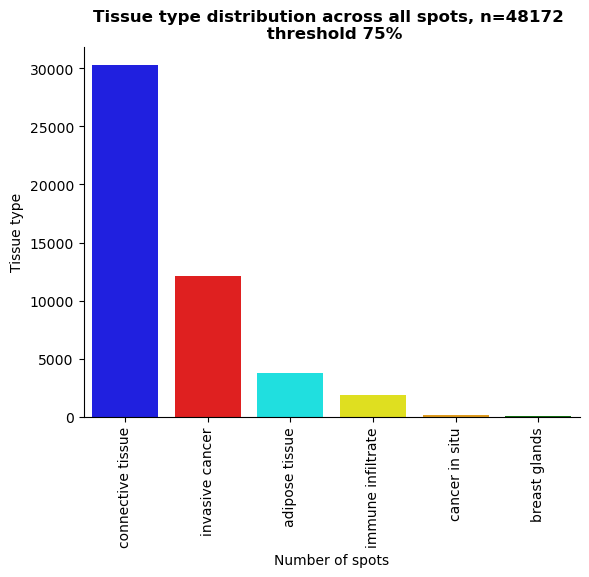

In [8]:
import seaborn as sns
PALETTE = {
    "invasive cancer": "red",
    "cancer in situ": "orange",
    "immune infiltrate": "yellow",
    "breast glands": "green",
    "connective tissue": "blue",
    "adipose tissue": "cyan",
    "undetermined": "lightgrey",
}

all_spots = pd.concat(all_summarized_annots)
not_defined_spots = all_spots[all_spots['label'] == 'undetermined']

all_defined_spots = all_spots[all_spots['label'] != 'undetermined']

sns.barplot(all_defined_spots['label'].value_counts(), palette=PALETTE)
sns.despine()
plt.xlabel("Number of spots")
plt.ylabel("Tissue type")
plt.title(f"Tissue type distribution across all spots, n={len(all_defined_spots)} \n threshold 75%", weight='bold')
plt.xticks(rotation=90)

In [9]:
10*9

90

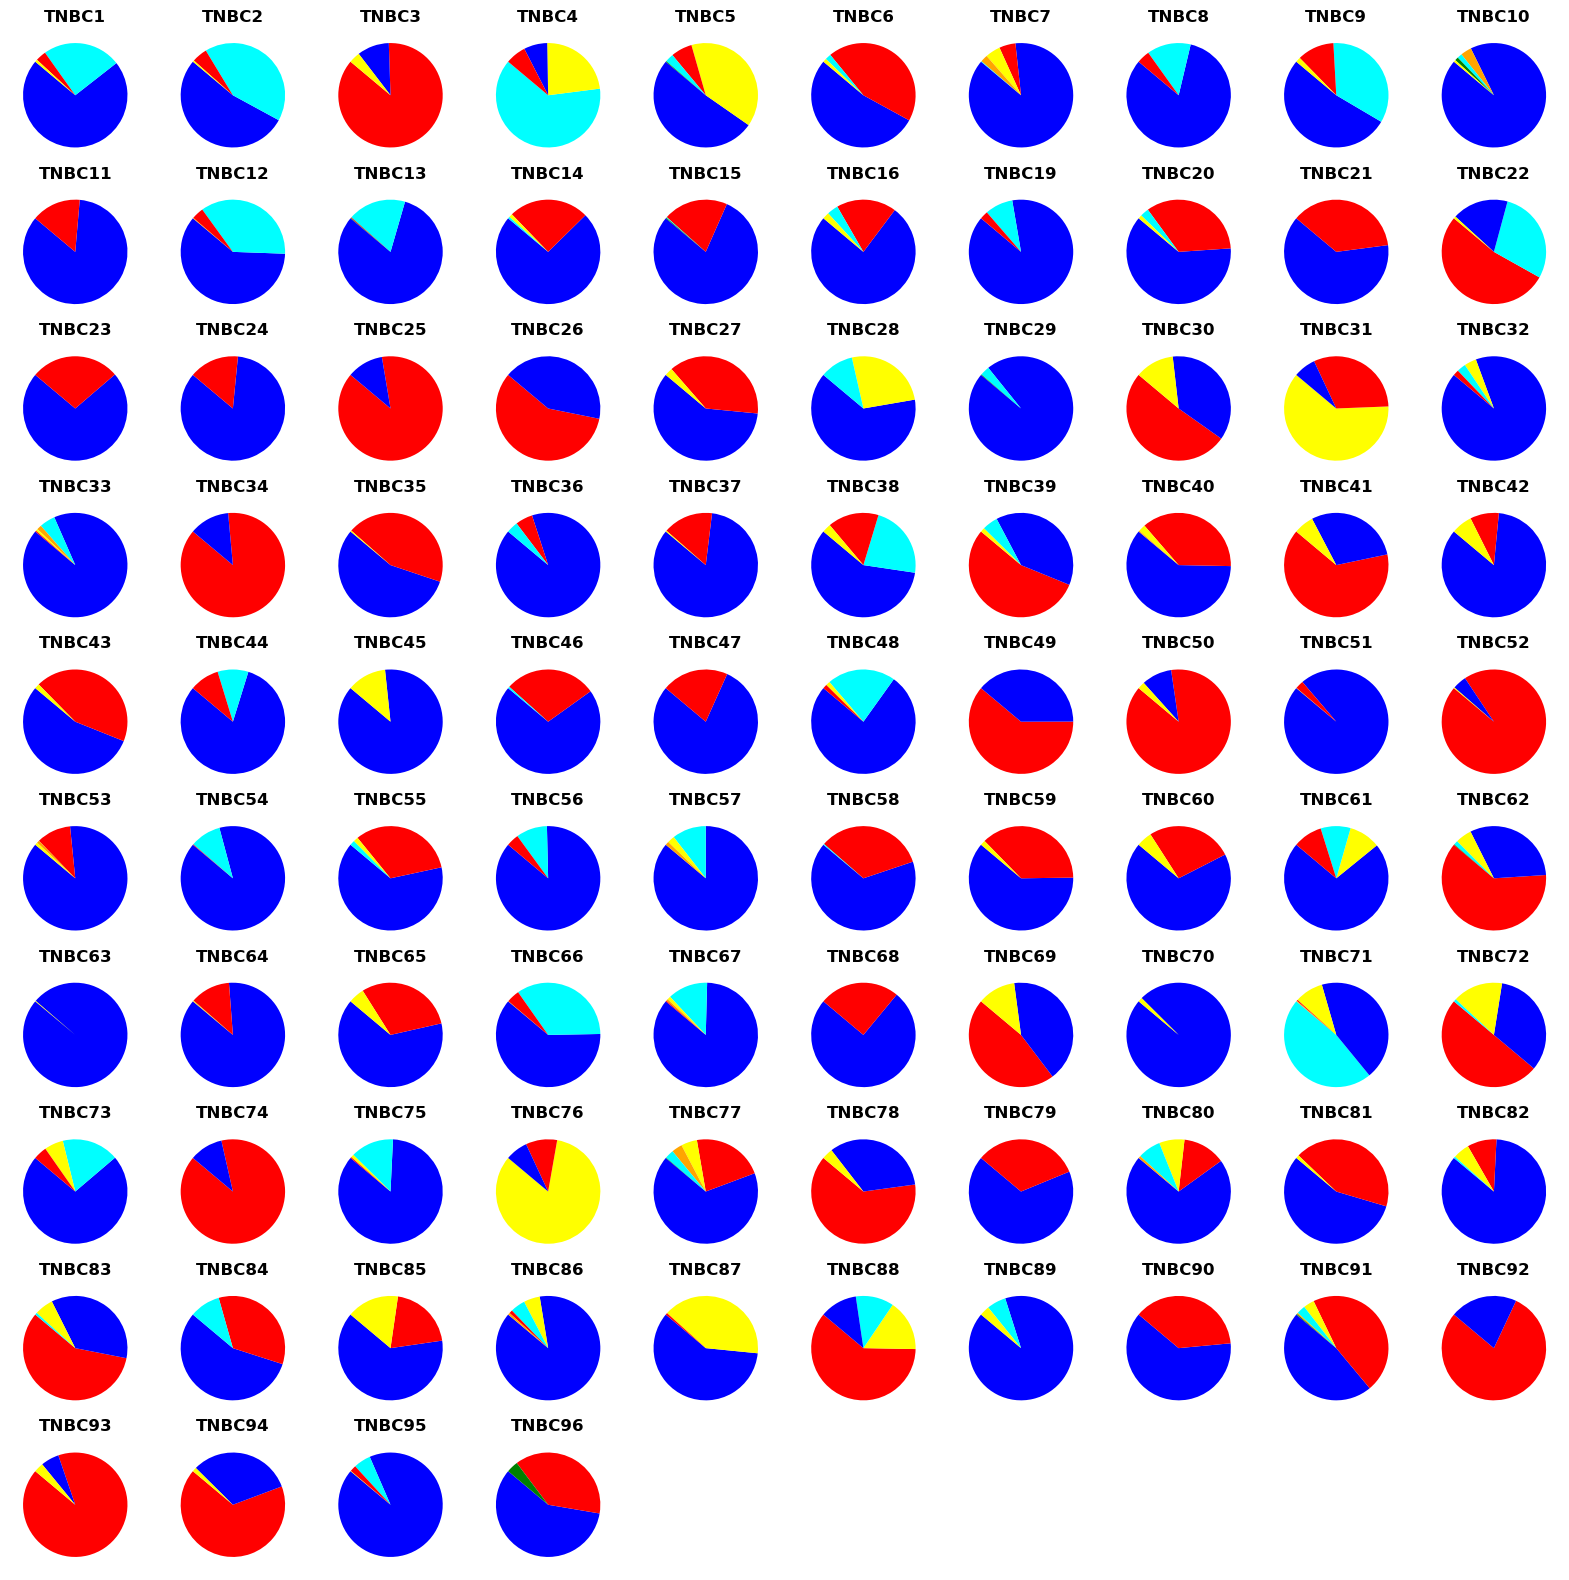

In [10]:
unique_source_files = all_defined_spots['source_file'].unique()

plt.figure(figsize=(20,20))

for src_file in unique_source_files:
    subset = all_defined_spots[all_defined_spots['source_file'] == src_file]
    label_counts = subset['label'].value_counts()
    pie_colors = [PALETTE.get(label, "grey") for label in label_counts.index]
    plt.subplot(10, 10, unique_source_files.tolist().index(src_file) + 1)
    plt.pie(label_counts, labels=None, autopct=None, startangle=140, colors=pie_colors)
    plt.title(f'{src_file}', weight='bold')


/idiap/temp/lfournier/tmp/ipykernel_2273775/3392639315.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('nipy_spectral', n_sources)


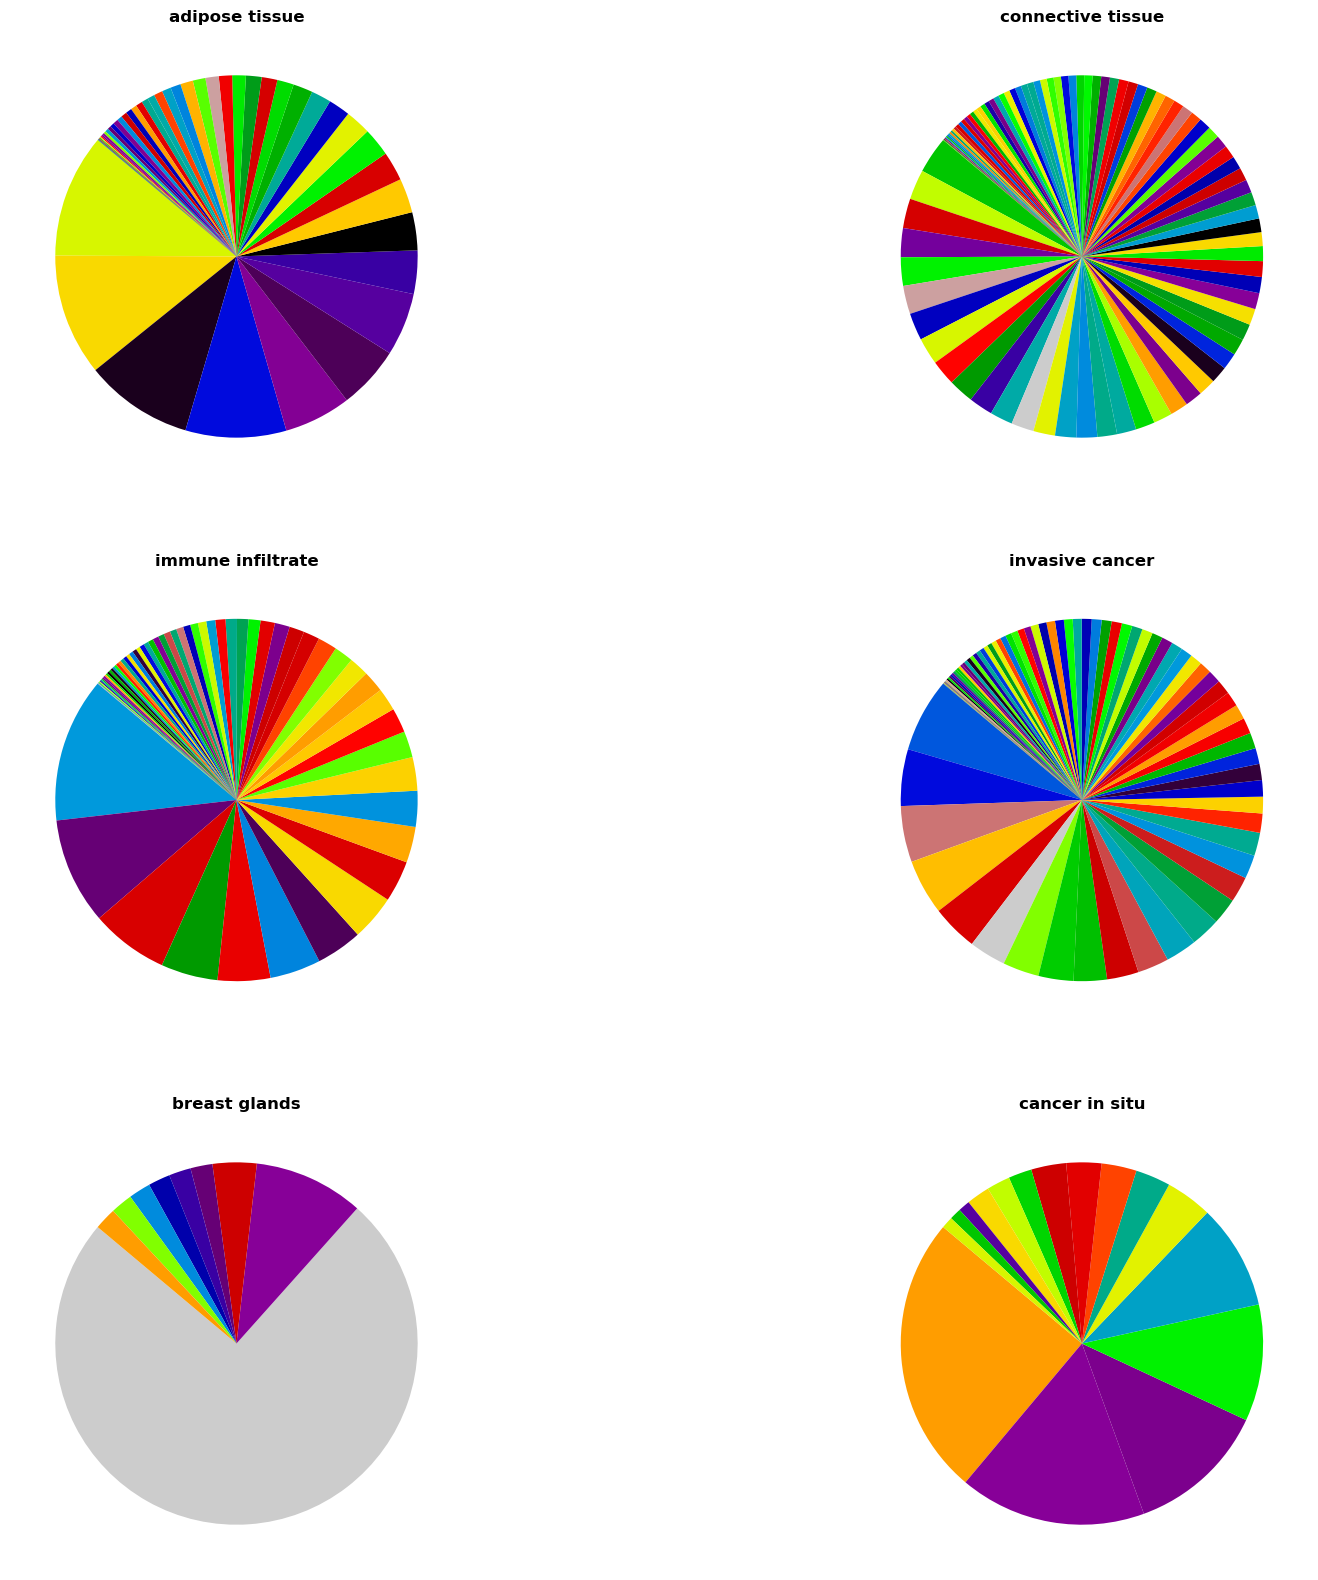

In [11]:
plt.figure(figsize=(20,20))

unique_tissues = all_defined_spots['label'].unique()
all_sources = all_defined_spots['source_file'].unique()
n_sources = len(all_sources)
cmap = plt.cm.get_cmap('nipy_spectral', n_sources)

for tissue in unique_tissues:
    subset = all_defined_spots[all_defined_spots['label'] == tissue]
    source_counts = subset['source_file'].value_counts()
    pie_colors = [cmap(all_sources.tolist().index(src)) for src in source_counts.index]
    plt.subplot(3, 2, unique_tissues.tolist().index(tissue) + 1)
    plt.pie(source_counts, labels=None, autopct=None, startangle=140, colors=pie_colors)
    plt.title(f'{tissue}', weight='bold')

In [12]:
patients_per_tissue = {}
for tissue in unique_tissues:
    subset = all_defined_spots[all_defined_spots['label'] == tissue]
    source_counts = subset['source_file'].value_counts()
    n_patients = len(source_counts)
    patients_per_tissue[tissue] = n_patients

# Sort the dictionary by number of patients (values) in descending order
patients_per_tissue_sorted = dict(sorted(patients_per_tissue.items(), key=lambda item: item[1], reverse=True))
print(patients_per_tissue_sorted)

{'connective tissue': 94, 'invasive cancer': 86, 'immune infiltrate': 64, 'adipose tissue': 50, 'cancer in situ': 16, 'breast glands': 9}


/idiap/temp/lfournier/tmp/ipykernel_2273775/1567497645.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=list(patients_per_tissue_sorted.values()), x=list(patients_per_tissue_sorted.keys()), palette=PALETTE)


Text(0.5, 1.0, 'Number of patients per tissue type \n threshold 75%')

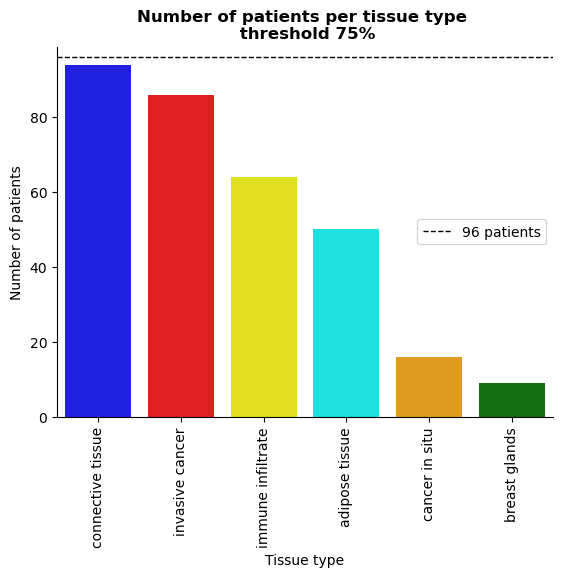

In [13]:
sns.barplot(y=list(patients_per_tissue_sorted.values()), x=list(patients_per_tissue_sorted.keys()), palette=PALETTE)
sns.despine()
plt.xlabel("Tissue type")
plt.ylabel("Number of patients")
plt.xticks(rotation=90)
plt.axhline(y=96, color='black', linestyle='--', linewidth=1, label='96 patients')
plt.legend()
plt.title(f"Number of patients per tissue type \n threshold 75%", weight='bold')

In [14]:
n_annotated_spots_per_patients = pd.DataFrame(all_defined_spots.value_counts('source_file')).reset_index()

In [15]:
n_annotated_spots_per_patients['n_p'] = n_annotated_spots_per_patients['source_file'].apply(lambda x: int(x.split('TNBC')[1]))

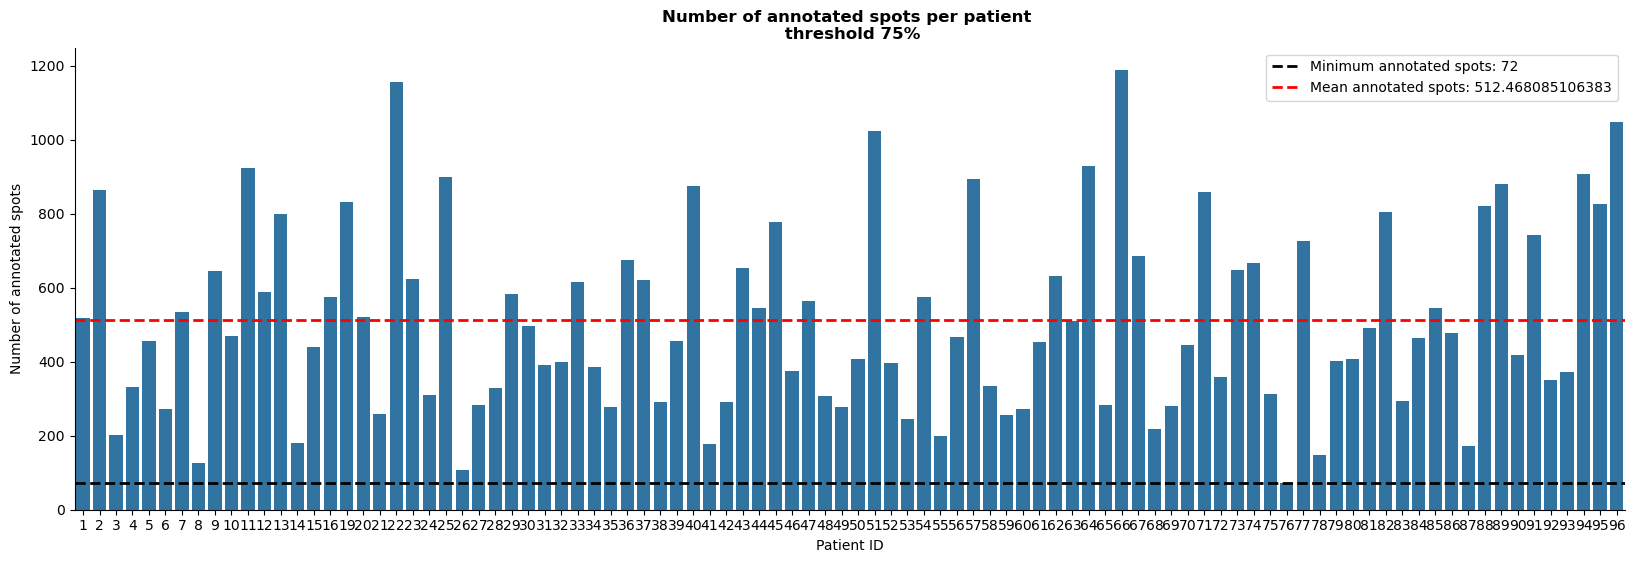

In [16]:
plt.figure(figsize=(20, 6))
sns.barplot(data=n_annotated_spots_per_patients, x='n_p', y='count')
sns.despine()
plt.xlabel("Patient ID")
plt.ylabel("Number of annotated spots")
plt.title(f"Number of annotated spots per patient \n threshold 75%", weight='bold')
plt.axhline(y=n_annotated_spots_per_patients['count'].min(), color='black', linestyle='--', linewidth=2, label=f"Minimum annotated spots: {n_annotated_spots_per_patients['count'].min()}")
plt.axhline(y=n_annotated_spots_per_patients['count'].mean(), color='red', linestyle='--', linewidth=2, label=f"Mean annotated spots: {n_annotated_spots_per_patients['count'].mean()}")
plt.legend()

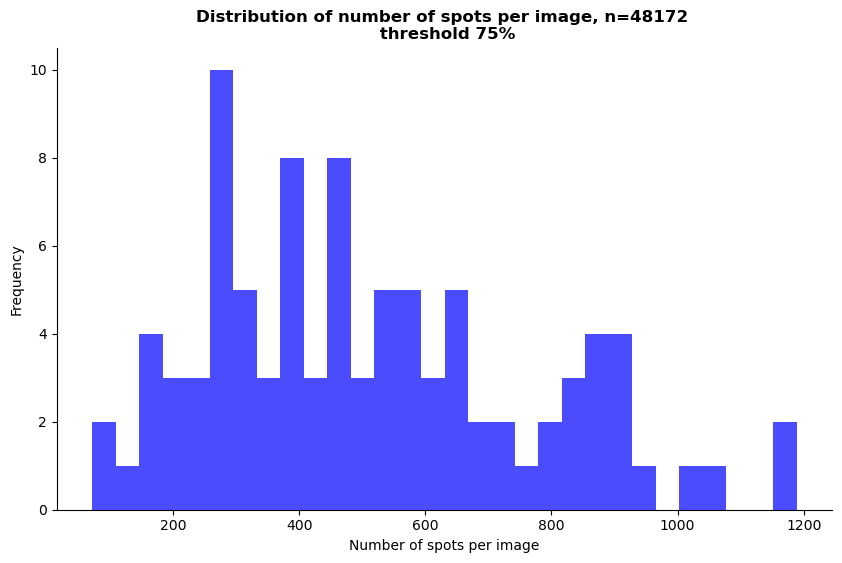

In [17]:
number_of_spots_per_image = all_defined_spots['source_file'].value_counts()

plt.figure(figsize=(10, 6))

plt.hist(number_of_spots_per_image, bins=30, color='blue', alpha=0.7)
plt.xlabel('Number of spots per image')
plt.ylabel('Frequency')
plt.title(f'Distribution of number of spots per image, n={len(all_defined_spots)} \n threshold 75%', weight='bold')
sns.despine()


In [18]:
images_filenames_spot_patches

['/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC1_CN1_C1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC2_CN1_E1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC3_CN2_C1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC4_CN2_D2.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC5_CN3_D1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC6_CN3_E1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC7_CN4_D1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC8_CN4_D2.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC9_CN5_D1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC10_CN5_E1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC11_CN6_C1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC12_CN6_E1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/imagesHD/TNBC13_CN7_C1.jpg',
 '/idiap/resource/database/ST_TNBC_v3/Images/im

In [ ]:
# UNCOMMENT TO GENERATE THE PATCHES USING ONLY THE ANNOTATED SLIDES

# from digitalhistopathology.patch_generator import PatchGenerator

# #Here we generate the patches corresponding to the spots ONLY. We do not add random patches.
# # Initialize the PatchGenerator
# patch_generator = PatchGenerator(
#     patch_size_pixels=spot_diameter,
#     patch_size_micron=None,
#     patches_number=None,
#     overlap_pixels=0,
#     extension="tiff",
#     filter_background=False,
#     saving_folder="results/compute_patches/TNBC/",
#     name_patches_info_file="patches_info.pkl.gz",
#     images_filenames_spot_patches=images_filenames_spot_patches,
#     spots_df=all_dataframes,
#     spot_mask=False,
#     spot_diameter=spot_diameter,
#     filter_with_neighbours=False,
#     log_file="logs/compute_patches.log",
# )
# patch_generator.compute_all_patches()


In [ ]:

# UNCOMMENT TO GENERATE THE PATCHES USING ALL SLIDES

from digitalhistopathology.patch_generator import PatchGenerator

#Here we generate the patches corresponding to the spots ONLY. We do not add random patches.
# Initialize the PatchGenerator
patch_generator = PatchGenerator(
    patch_size_pixels=spot_diameter,
    patch_size_micron=None,
    patches_number=None,
    overlap_pixels=0,
    extension="tiff",
    filter_background=True,
    saving_folder="results/compute_patches/TNBC_all/",
    name_patches_info_file="patches_info.pkl.gz",
    images_filenames_spot_patches=images_filenames_spot_patches,
    spots_df=all_dataframes,
    spot_mask=False,
    spot_diameter=spot_diameter,
    filter_with_neighbours=False,
    log_file="logs/compute_patches.log",
)
patch_generator.compute_all_patches()


281

In [22]:
all_dataframes[0]

,Nothing,Tumor,Necrosis,Fat tissue,Low TIL stroma,Vessels,Artefacts,Lactiferous duct,High TIL stroma,in situ,...,source_file,x,y,new_x,new_y,pixel_x,pixel_y,selected,total_pixels_excluding_nothing,cancer_pixels
2x12,6168,0,0,1646,2743,0,0,0,0,0,...,TNBC1,2,12,2.04,12.05,4869.666667,5108.000000,1,4389,0
2x14,0,0,0,4565,5992,0,0,0,0,0,...,TNBC1,2,14,2.05,14.08,4872.000000,5922.333333,1,10557,0
2x16,0,0,0,4577,5980,0,0,0,0,0,...,TNBC1,2,16,2.03,16.05,4864.000000,6711.333333,1,10557,0
2x18,0,0,0,10557,0,0,0,0,0,0,...,TNBC1,2,18,2.03,18.04,4864.333333,7513.000000,1,10557,0
2x20,0,0,0,10557,0,0,0,0,0,0,...,TNBC1,2,20,2.07,20.04,4879.000000,8315.000000,1,10557,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65x53,348,1099,0,0,0,0,0,0,0,0,...,TNBC1,65,53,65.02,52.98,27544.666667,21531.000000,1,10209,1099
65x55,0,437,0,0,0,0,0,0,0,0,...,TNBC1,65,55,65.06,55.02,27559.666667,22347.000000,1,10557,437
65x57,686,560,0,2206,0,0,0,0,0,0,...,TNBC1,65,57,65.05,56.94,27555.666667,23117.000000,1,9871,560
65x59,1528,1035,0,0,0,0,0,0,0,0,...,TNBC1,65,59,65.05,58.99,27553.666667,23939.000000,1,9029,1035


In [36]:
# import os
# import rpy2.robjects as robjects
# from rpy2.robjects import pandas2ri
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# # Activate the automatic conversion of R objects to pandas objects
# pandas2ri.activate()

# # Base directory and number of WSI
# dataDir = "/idiap/resource/database/ST_TNBC_v3"
# number_of_wsi = 96

# # Generate all RDS file paths
# annotsBySpot = natsorted(glob.glob(f"{dataDir}/Robjects/annotsBySpot/TNBC*.RDS"))

# # Initialize an empty list to store DataFrames
# annots_dfs = []

# # Process each RDS file
# for spots_df, annots in zip(spots_dfs,annotsBySpot):

#     try:
#         # Read the RDS file
#         loaded_data = robjects.r['readRDS'](annots)

#         # Extract 'annots'
#         names = loaded_data.names
#         for i, name in enumerate(names):
#             if name == 'annots':
#                 annots = loaded_data[i]
#         annots_df = convert_to_df(annots)
#         annots_dfs.append(annots_df)
#         # Add a column to track the source file
    

#     except Exception as e:
#         print(f"Error processing {spots}: {e}")# Combine all DataFrames into one giant DataFrame

# # Ensure the relevant columns are present
# cancer_columns = ['Tumor', 'in situ', 'Tumor region']
# full_spots_dfs = []
# cancer_spots_dfs = []
# for spots_df,annots_df in zip(spots_dfs, annots_dfs):
#     annots_df['total_pixels_excluding_nothing'] = annots_df.drop(columns=['Nothing']).sum(axis=1)
#     print(len(annots_df[
#         annots_df['Nothing'] / annots_df['total_pixels_excluding_nothing'] == 0]))
#     full_spots_dfs.append(spots_df[
#         annots_df['Nothing'] / annots_df['total_pixels_excluding_nothing'] == 0])

#     # Calculate the total number of pixels excluding the "Nothing" column


#     # Sum the values in the cancer-related columns
#     annots_df['cancer_pixels'] = annots_df[cancer_columns].sum(axis=1)

#     # Filter out rows where total_pixels_excluding_nothing <= 0
#     annots_df = annots_df[annots_df['total_pixels_excluding_nothing'] > 0]

#     # Calculate the condition
#     annots_df['meets_condition'] = (
#         annots_df['cancer_pixels'] / annots_df['total_pixels_excluding_nothing'] > cancer_percentage_thresholed
#     )
#     cancer_spots_dfs.append(spots_df[annots_df['meets_condition']])
#     print(len(annots_df[annots_df['meets_condition']]))

    





In [37]:
from cmath import rect
import os
from PIL import Image, ImageDraw


from networkx import reconstruct_path
from numpy import rec
Image.MAX_IMAGE_PIXELS = None
# Define the data directory
data_dir = "/idiap/resource/database/ST_TNBC_v3/"  # Replace this with the actual path to your data directory

# Function to draw spots on annotated images and save as PNG
def draw_spots_on_image(image_path, spots_path, output_path,rect_length):
    # Read the annotated image
    img = Image.open(image_path)

    # Read the spot data using rpy2
    ro.r('library(EBImage)')
    spots_data = ro.r['readRDS'](spots_path)
    spots_df = convert_to_df(spots_data)
    spots_df = spots_df[spots_df['selected'] == 1]
    if spots_df is None:
        raise ValueError("Failed to convert spots data to DataFrame")

    # Scale spot coordinates to match the image dimensions
    img_width, img_height = img.size
    spots_df['pixel_x'] = spots_df['pixel_x'] * img_height / 9523
    spots_df['pixel_y'] = spots_df['pixel_y'] * img_height / 9523

    # Ensure the output directory exists
    output_dir = os.path.dirname(output_path)
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Create a drawing context
    draw = ImageDraw.Draw(img)

    # Define the length of the rectangle
    rect_length = rect_length
    half_length = rect_length / 2

    # Draw rectangles on the image
    for x, y in zip(spots_df['pixel_x'], spots_df['pixel_y']):
        draw.rectangle(
            [x - half_length, y - half_length, x + half_length, y + half_length],
            outline='red',
            width=5
        )

    # Save the image
    img.save(output_path, 'PNG')

# Example usage
image_path = os.path.join(data_dir, "Images/imagesHD/TNBC19_CN10_D1.jpg")
spots_path = os.path.join(data_dir, "byArray/CN10/D1/allSpots.RDS")
output_path = "STTNBC/HDTNBC36_spots.png"

draw_spots_on_image(image_path, spots_path, output_path,rect_length=387)


Number of spots that meet the condition: 0
Total number of spots: 96706
source_file
allSpots.RDS    0
Name: meets_condition, dtype: int64
source_file
allSpots.RDS    False
Name: meets_condition, dtype: bool


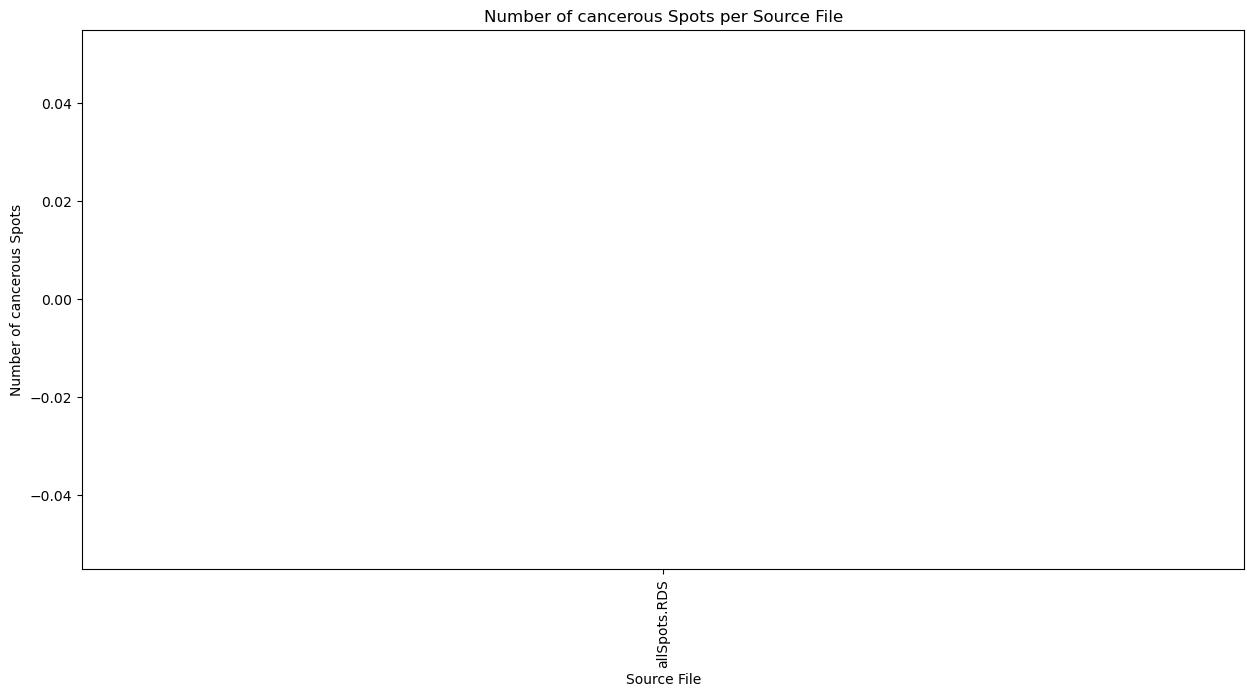

In [38]:
import os
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Activate the automatic conversion of R objects to pandas objects
pandas2ri.activate()

# Base directory and number of WSI
dataDir = "/idiap/resource/database/ST_TNBC_v3"
number_of_wsi = 96

# Generate all RDS file paths
annotsBySpot = natsorted(glob.glob(f"{dataDir}/Robjects/annotsBySpot/TNBC*.RDS"))

# Initialize an empty list to store DataFrames
all_dataframes = []

# Process each RDS file
for spots_df, annots in zip(spots_dfs,annotsBySpot):

    try:
        # Read the RDS file
        loaded_data = robjects.r['readRDS'](annots)

        # Extract 'annots'
        names = loaded_data.names
        for i, name in enumerate(names):
            if name == 'annots':
                annots = loaded_data[i]
        annots_df = convert_to_df(annots)
        annots_df['source_file'] = os.path.basename(spots)
        merged_dfs = pd.merge(annots_df, spots_df, left_index=True, right_index=True, suffixes=('_spot', '_annot'))

        # Add a column to track the source file
        
        # Append to the list of DataFrames
        all_dataframes.append(merged_dfs)

    except Exception as e:
        print(f"Error processing {spots}: {e}")# Combine all DataFrames into one giant DataFrame
merged_dfs = pd.concat(all_dataframes, ignore_index=True)

# Ensure the relevant columns are present
cancer_columns = ['Tumor', 'in situ', 'Tumor region']
merged_dfs['total_pixels_excluding_nothing'] = merged_dfs.drop(columns=['Nothing','source_file']).sum(axis=1)
full_spots = merged_dfs[
    merged_dfs['Nothing'] / merged_dfs['total_pixels_excluding_nothing'] == 0]

# Calculate the total number of pixels excluding the "Nothing" column


# Sum the values in the cancer-related columns
merged_dfs['cancer_pixels'] = merged_dfs[cancer_columns].sum(axis=1)

# Filter out rows where total_pixels_excluding_nothing <= 0
merged_dfs = merged_dfs[merged_dfs['total_pixels_excluding_nothing'] > 0]

# Calculate the condition
merged_dfs['meets_condition'] = (
    merged_dfs['cancer_pixels'] / merged_dfs['total_pixels_excluding_nothing'] > cancer_percentage_thresholed
)
cancer_spots = merged_dfs[merged_dfs['meets_condition']]

# Number of spots that meet the condition
num_spots_meet_condition = merged_dfs['meets_condition'].sum()

# Total number of spots
total_spots = len(merged_dfs)


# Print the results
print(f"Number of spots that meet the condition: {num_spots_meet_condition}")
print(f"Total number of spots: {total_spots}")
print(merged_dfs.groupby('source_file')['meets_condition'].sum())


# Plot histogram of the number of spots that meet the condition per source file
merged_dfs.groupby('source_file')['meets_condition'].sum().plot(kind='bar', figsize=(15, 7))
print(merged_dfs.groupby('source_file')['meets_condition'].sum() > 0)
plt.xlabel('Source File')
plt.ylabel('Number of cancerous Spots')
plt.title('Number of cancerous Spots per Source File')
plt.show()

In [39]:
# Group by source_file and calculate the counts for meeting and not meeting the condition
grouped = merged_dfs.groupby('source_file')['meets_condition'].value_counts().unstack(fill_value=0)

# Add missing files with no entries for clarity
grouped = grouped.reindex(index=merged_dfs['source_file'].unique(), fill_value=0)

# Rename columns for clarity
grouped.columns = ['Not Cancer', 'Cancer']

# Plot the stacked bar chart
grouped.plot(kind='bar', figsize=(15, 7), stacked=True, color=['blue', 'red'])

# Add labels and title
plt.xlabel('Source File')
plt.ylabel('Total Number of Spots')
plt.title('Stacked Bar Chart of Spots per Source File')

# Add a legend
plt.legend(title='Condition', labels=['Not Cancer', 'Cancer'])

# Show the plot
plt.show()

ValueError: Length mismatch: Expected axis has 1 elements, new values have 2 elements